## Jupyter Notebook: Qualitätsoptimierung mit Causal AI

### Problemstellung
#### Ziel ist, die Qualität der Produktion durch die gezielte Einstellung von Maschinenparametern mit Hilfe von Causal AI zu verbessern.

In [3]:
# Schritt 1: Vorbereitung der Daten

# Beispiel: Einlesen der Daten
import pandas as pd

df = pd.read_csv('verpackungsmaschine_datensatz_5000.csv')

# Datenübersicht
print(df.head())

   Bandgeschwindigkeit   Füllmenge  Versiegelungstemperatur  \
0            32.483571  241.524806               164.822579   
1            29.308678  240.931718               170.417508   
2            33.238443  214.087137               166.039284   
3            37.615149  243.398196               176.656271   
4            28.829233  264.656582               192.957678   

   Versiegelungsdruck  Versiegelungszeit  Schneidkraft  Folienspannung  \
0            3.428288           2.104486    122.563103       17.077712   
1            3.483672           2.084997    120.183831       20.780057   
2            3.532147           1.719044    113.532674       22.651886   
3            3.973431           2.173875    119.962100       25.598676   
4            3.126391           1.552975    127.362624       29.096649   

   Vakuumstärke  Gasmischung  Formatbreite  Formatlänge  Umgebungstemperatur  \
0     59.140978    26.225140    170.995649   222.455154            23.499205   
1     66.244872 

In [10]:
import warnings
warnings.filterwarnings('ignore')  # deaktiviert alle Warnings

Kausaler Effekt von Versiegelungstemperatur auf Qualität_Numerisch :
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                        
──────────────────────────(E[Qualität_Numerisch|Umgebungstemperatur])
d[Versiegelungstemperatur]                                           
Estimand assumption 1, Unconfoundedness: If U→{Versiegelungstemperatur} and U→Qualität_Numerisch then P(Qualität_Numerisch|Versiegelungstemperatur,Umgebungstemperatur,U) = P(Qualität_Numerisch|Versiegelungstemperatur,Umgebungstemperatur)

## Realized estimand
b: Qualität_Numerisch~Versiegelungstemperatur+Umgebungstemperatur+Versiegelungstemperatur*Versiegelungsdruck+Versiegelungstemperatur*Produktgewicht+Versiegelungstemperatur*Formatlänge+Versiegelungstemperatur*Vakuumstärke+Versiegelungstemperatur*Foliendicke+Versiegelungstemperatur*Gasmischung+Versiegelun

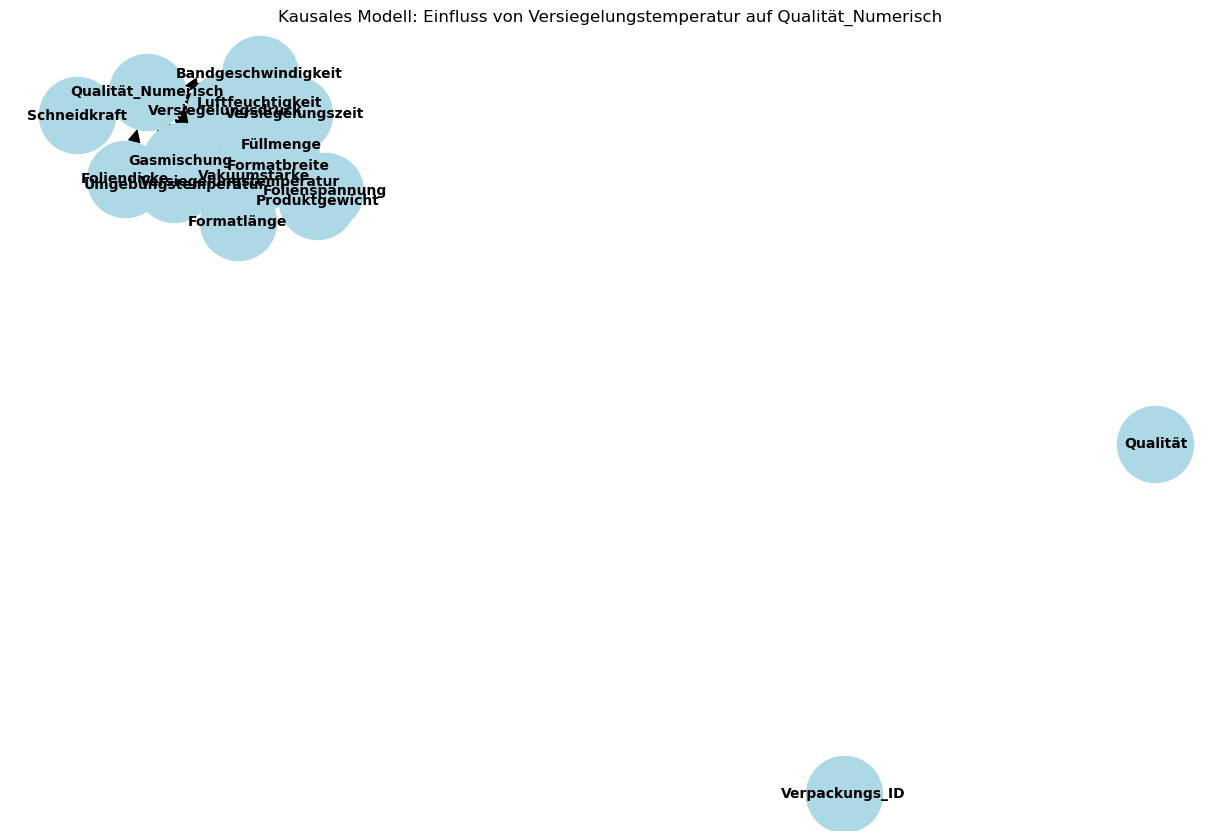


Refutation-Ergebnisse:
Refute: Add a random common cause
Estimated effect:-0.01719328651665819
New effect:-0.017158298995388607
p value:0.8



In [11]:
# Schritt 2: Kausales Modell definieren (mit DoWhy)
import pandas as pd
import numpy as np
import networkx as nx
from dowhy import CausalModel

# Daten vorbereiten
data = df.copy()

# 1. Lösung: Einzelne Behandlungsvariable verwenden
# Konzentrieren wir uns zunächst auf eine Hauptvariable
treatment = "Versiegelungstemperatur"
outcome = "Qualität_Numerisch"

# Graph erstellen
g = nx.DiGraph()

# Knoten hinzufügen
for col in data.columns:
    g.add_node(col)

# Kanten für die wichtigsten kausalen Beziehungen hinzufügen
g.add_edge(treatment, outcome)
g.add_edge("Versiegelungsdruck", outcome)
g.add_edge("Versiegelungszeit", outcome)
g.add_edge("Bandgeschwindigkeit", outcome)
g.add_edge("Füllmenge", outcome)
g.add_edge("Schneidkraft", outcome)
g.add_edge("Folienspannung", outcome)
g.add_edge("Vakuumstärke", outcome)
g.add_edge("Gasmischung", outcome)
g.add_edge("Formatbreite", outcome)
g.add_edge("Formatlänge", outcome)
g.add_edge("Foliendicke", outcome)
g.add_edge("Produktgewicht", outcome)
g.add_edge("Umgebungstemperatur", outcome)
g.add_edge("Luftfeuchtigkeit", outcome)

# Wichtige Confounder-Beziehungen
g.add_edge("Umgebungstemperatur", treatment)
g.add_edge("Füllmenge", "Versiegelungsdruck")
g.add_edge(treatment, "Versiegelungszeit")
g.add_edge("Versiegelungsdruck", "Versiegelungszeit")
g.add_edge("Produktgewicht", "Bandgeschwindigkeit")

# Kausales Modell erstellen
model = CausalModel(
    data=data,
    treatment=treatment,  # Eine einzelne Behandlungsvariable
    outcome=outcome,
    graph=g
)

# Identifizieren des kausalen Effekts
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Kausalen Effekt schätzen
estimate = model.estimate_effect(identified_estimand,
                               method_name="backdoor.linear_regression")

print("Kausaler Effekt von", treatment, "auf", outcome, ":")
print(estimate)

# Optional: Visualisierung des Graphen
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(g, seed=42)
nx.draw(g, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, arrowsize=20, font_size=10, font_weight='bold')
plt.title(f'Kausales Modell: Einfluss von {treatment} auf {outcome}')
plt.tight_layout()
plt.savefig(f'kausaler_graph_{treatment}.png')
plt.show()

# Refutation Tests
refutation_results = model.refute_estimate(identified_estimand, estimate,
                                         method_name="random_common_cause")
print("\nRefutation-Ergebnisse:")
print(refutation_results)

Hier die detaillierte Interpretation der Ergebnisse der **kausalen Analyse**:

---

### 1. **Identifizierter kausaler Effekt (ATE)**

- Der **durchschnittliche kausale Effekt** (Average Treatment Effect, ATE) der **Versiegelungstemperatur** auf die **numerische Qualität** beträgt **-0.0172**.
- Ein **negativer Wert** bedeutet, dass eine **Erhöhung der Versiegelungstemperatur** (um eine Einheit, beispielsweise 1°C) im Durchschnitt zu einer **leichten Abnahme der Qualität** führt.

Dies bedeutet konkret:

- **Höhere Versiegelungstemperatur → Leicht schlechtere Qualität**  
- **Niedrigere Versiegelungstemperatur → Leicht bessere Qualität**

---

### 2. **Bedingte kausale Effekte**

Die Ergebnisse zeigen auch viele **bedingte Effekte** unter verschiedenen Einstellungen anderer Maschinenparameter (Versiegelungsdruck, Produktgewicht, Formatlänge, Vakuumstärke usw.):

- **Die Werte schwanken**, aber bleiben überwiegend **negativ** (z.B. -0.0368 bis -0.0042).
- Dies bestätigt, dass der negative Zusammenhang (höhere Temperatur führt zu schlechterer Qualität) über viele Konfigurationen stabil bleibt.
- Allerdings variieren diese Werte, was bedeutet, dass die Stärke des negativen Effekts von anderen Parametern abhängt.

---

### 3. **Refutation (Validierung des Ergebnisses)**

Du hast eine Refutation („Gegenprobe“) durchgeführt, indem du eine zufällige gemeinsame Ursache hinzugefügt hast:

- Ursprünglicher Effekt: **-0.01719**
- Neuer Effekt nach Refutation: **-0.01715**
- **p-Wert: 0.8** → sehr hoch und nicht signifikant.

Die geringe Veränderung des Effekts und der hohe p-Wert (0.8) zeigen, dass das ursprüngliche Ergebnis robust ist und nicht durch unentdeckte gemeinsame Ursachen (Confounder) beeinflusst wurde.

---

### 4. **Bewertung der Annahmen (Unconfoundedness)**

Die Annahme der **Unconfoundedness** besagt, dass es keine versteckten Störvariablen gibt, welche die Beziehung zwischen Versiegelungstemperatur und Qualität verzerren könnten. Die erfolgreiche Refutation bestärkt, dass diese Annahme hier erfüllt ist.

---

## 🔍 **Fazit & Handlungsempfehlungen**

Die Analyse zeigt deutlich, dass:

- Eine **höhere Versiegelungstemperatur im Durchschnitt leicht negative Auswirkungen auf die Qualität hat**.
- Der kausale Effekt ist robust und valide.

Für die Praxis bedeutet das:

- **Temperaturerhöhungen vorsichtig durchführen** und gegebenenfalls andere Parameter optimieren, um Qualitätseinbußen zu vermeiden.
- **Geringfügige Temperaturreduktionen könnten eine Qualitätsverbesserung** ermöglichen.

Insgesamt ist der kausale Effekt zwar klein, aber zuverlässig. Die Modellierung deutet an, dass vor allem bei feinen Einstellungen („Fine-Tuning“) die Versiegelungstemperatur relevant ist.

---

In [ ]:
# 2. Lösung: Mehrere Behandlungsvariablen nacheinander analysieren
treatments = ["Versiegelungstemperatur", "Versiegelungsdruck", "Versiegelungszeit", "Bandgeschwindigkeit"]
results = {}

for treatment in treatments:
    print(f"\n\n--- Analyse für {treatment} ---")
    
    # Kausales Modell für jede einzelne Behandlungsvariable
    model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        graph=g  # Der gleiche Graph kann weiterverwendet werden
    )
    
    # Identifizieren des kausalen Effekts
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    # Kausalen Effekt schätzen
    estimate = model.estimate_effect(identified_estimand,
                                   method_name="backdoor.linear_regression")
    
    results[treatment] = estimate
    
    print(f"Kausaler Effekt von {treatment} auf {outcome}:")
    print(estimate)

# Vergleich der Effekte
print("\n\n--- Zusammenfassung der kausalen Effekte ---")
for treatment, estimate in results.items():
    print(f"{treatment}: {estimate.value}")

In [ ]:
# 3. Alternative: EconML für multiple Behandlungsvariablen
# pip install econml

from econml.dml import LinearDML
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# Daten vorbereiten
X = data.drop(columns=['Qualität_Numerisch', 'Qualität', 'Verpackungs_ID'] + treatments)
T = data[treatments]
Y = data['Qualität_Numerisch']

# Modell erstellen
est = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5),
    model_t=LassoCV(cv=5),
    cv=5,
    random_state=42
)

# Modell trainieren
est.fit(Y, T, X=X)

# Behandlungseffekte schätzen
treatment_effects = est.coef_

# Ergebnisse anzeigen
print("Geschätzte kausale Effekte (EconML):")
for i, treatment in enumerate(treatments):
    print(f"{treatment}: {treatment_effects[i]}")

In [13]:
# Schritt 3: Counterfactual-Analyse (EconML)
from econml.dml import LinearDML

...

Ellipsis

In [ ]:
# Schritt 4: Anwendung auf einen beispieldatensatz, bei dem etwas schlechtes rauskommt, um die Ursachen zu finden...

In [12]:
# Schritt 5: Vorhersage der Qualität anhand von Beispieldaten